In [3]:
from __future__ import division
import os
from os.path import join
import numpy as np
import pandas as pd

%pylab inline

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [4]:
# paths to subject dir
subj = '13034'
dataDir = '../data'

# Classification 
Classification analyses on one subject. This notebook walks through the steps for prepping the data, and setting up a classification.

This experiment was a single run task with 48 trials. On each trial, subjects were presented with a stimulus in the form of either a **Word** or a **Picture** (24 stims from each modality).

Stimuli represented either **Dwellings** or **Tools** (equally balanced across modalities). 

There were 8 unique stimuli. 

** Stimuli Breakdown:**

* 24 Words
    * 12 Dwellings
        * 4 stims (as words), repeated 3x each
    * 12 Tools 
        * 4 stims (as words), repeated 3x each
* 24 Pics
    * 12 Dwellings
        * 4 stims (as pics), repeated 3x each
    * 12 Tools
        * 4 stims (as pics), repeated 3x each


The analyses will focus on classifying between different combinations of these stimuli representations (e.g. classifying between words and pics)

# Preprocessing

---
## Prepare the attributes
Prepare a set of volume labels that can be used to slice the dataset up for different analyses.  

In [5]:
# read trialOnsets file
trialOnsets = pd.read_table(join(dataDir, subj, (subj + '_trialOnsets.txt')))
trialOnsets.head()

,TrialOnset,Modality,Category,Stimulus
0,2000,Word,dwelling,castle
1,11995,Word,tool,saw
2,22007,Word,dwelling,house
3,32002,Word,dwelling,tent
4,41980,Word,tool,screwdriver


In [6]:
# drop the trial onset times, as we don't need that
trials = trialOnsets.drop('TrialOnset', axis=1)
trials.shape

(48, 3)

### Make additional columns for category by word/pic and stim by word/pic

In [7]:
def catByWord(row):
    if row['Modality'] == 'Word':
        label = row['Category'] + 'Word'
    else:
        label = 'n'
    return label

def catByPic(row):
    if row['Modality'] == 'Picture':
        label = row['Category'] + 'Pic'
    else:
        label = 'n'
    return label

def stimByWord(row):
    if row['Modality'] == 'Word':
        label = row['Stimulus'] + 'Word'
    else:
        label = 'n'
    return label

def stimByPic(row):
    if row['Modality'] == 'Picture':
        label = row['Stimulus'] + 'Pic'
    else:
        label = 'n'
    return label

In [8]:
trials['categoryWords'] = trials.apply(catByWord, axis=1)
trials['categoryPics'] = trials.apply(catByPic, axis=1)
trials['stimulusWords'] = trials.apply(stimByWord, axis=1)
trials['stimulusPics'] = trials.apply(stimByPic, axis=1)

Here is the table that contains all of our sample labels

In [9]:
trials.head()

,Modality,Category,Stimulus,categoryWords,categoryPics,stimulusWords,stimulusPics
0,Word,dwelling,castle,dwellingWord,n,castleWord,n
1,Word,tool,saw,toolWord,n,sawWord,n
2,Word,dwelling,house,dwellingWord,n,houseWord,n
3,Word,dwelling,tent,dwellingWord,n,tentWord,n
4,Word,tool,screwdriver,toolWord,n,screwdriverWord,n


## Load the subject's brain data

For this analysis, the functional data has been preprocessed with the following steps:

* motion correction
* non-brain removal with BET (along with func mask creation)
* 4mm smoothing
* highpass filtered (Gaussian least-squares straight-line fitting, sigma=40.0s)

In addition, we ran first level GLMs to extract SPMs that represented single trial parameter estimates. For each trial, a model was fit with two regressors: 1) convolved regressor representing THAT trial, and 2) convolved regressor representing ALL OTHER trials. The unique parameter estimate map for each trial was extracted and merged across time to produce a 4D file. There are 48 'timepts' in this 4D file, each representing the whole brain parameter map for a single trial

The 4D single-trial parameter maps will be used as the input dataset for our classification

In [10]:
# import tools to read nifti data
import nilearn as nl
import nibabel as nib

In [11]:
subj_dataDir = join(dataDir, subj)
bold_file = join(subj_dataDir, 'singleTrialGLM/singleTrialPEs.nii.gz')
mask_file = join(subj_dataDir, 'masks/TDSL2_brain_mask.nii.gz')

In [12]:
# create a Nilearn Masker...this will convert the dataset to a 2D array
# as well as standardize the voxel timeseries
from nilearn.input_data import NiftiMasker

In [13]:
masker = NiftiMasker(mask_img=mask_file, standardize=True)
fmri_masked = masker.fit_transform(bold_file)
fmri_masked.shape

(48, 25182)

# Start Classifying

In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

### Start simple - whole brain SVM on Words vs Pics
See how well an SVM can discrimate between WORD trials and PIC trials using the entire brain volume as input

In [38]:
# load decoder
from sklearn.svm import SVC

In [58]:
# test how well stratified K-fold does the trick
skf = StratifiedKFold(n_splits=5, random_state=1)

In [62]:
model = SVC(kernel='linear')
X = fmri_masked
y = trials['Modality']

# run leave one out cross validation on this model
cv_scores = cross_val_score(model, X, y, cv=skf, n_jobs=4)
print(cv_scores.mean())

0.62


In [68]:
from sklearn.model_selection import train_test_split

In [70]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.25, random_state=1)

In [71]:
model.fit(Xtrain, ytrain)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [76]:
model.predict(Xtest)

array(['Word', 'Word', 'Word', 'Word', 'Picture', 'Word', 'Word',
       'Picture', 'Word', 'Word', 'Word', 'Word'], dtype=object)

In [79]:
coef = model.coef_
print(coef.shape)

(1, 25182)


In [80]:
coef_img = masker.inverse_transform(coef)

In [82]:
from nilearn import plotting

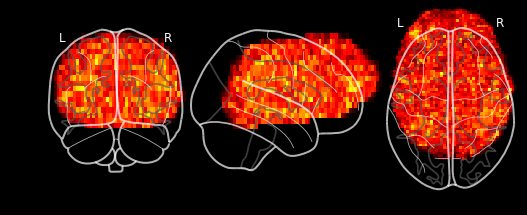

In [83]:
plotting.plot_glass_brain(coef_img, black_bg=True)

In [84]:
from nilearn.plotting import plot_stat_map, show

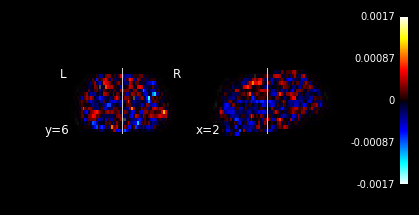

In [89]:
plot_stat_map(coef_img, bg_img=join(dataDir, subj, 'preprocessed.feat/example_func.nii.gz'), display_mode='yx')